## Time-Series Analysis using CNN-LSTM: Dhaka Tribune

Dataset: Dhaka Tribune 2021 Dataset

Resampling Technique: Every 3 Days

* Training Period: 2020-03-31 to 2021-03-26
* Test/Validation Period: 2021-03-27 to 2021-06-25

Author: Sumaia Parveen Shupti

Created on: 07/10/2021

Updated on: 07/15/2021

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

### Load & Preprocess Dataset

In [2]:
df = pd.read_csv('../input/dhakatribunecomplete/Dhaka Tribune Complete Data.csv')
df['Accident date'] = pd.to_datetime(df['Accident date'])

df = df[['Accident date', 'Deaths']]
df.columns = ['Period', 'Deaths']
df = df.sort_values(by = 'Period')
df = df.reset_index(drop = True).set_index('Period').resample('3D').sum()
df = df.reset_index()
df['Period'] = df['Period'].dt.date
df['Deaths'] = df['Deaths'].fillna(0)
df = df.set_index('Period')
df

,Deaths
Period,
2016-06-24,3.0
2016-06-27,0.0
2016-06-30,0.0
2016-07-03,0.0
2016-07-06,0.0
...,...
2021-06-13,8.0
2021-06-16,9.0
2021-06-19,7.0


### Splitting into Train & Test Sets

In [3]:
start_ = df.index.max()
end_ = df.index.min()

test_end = df.index.max()
test_start = df.index.max() - timedelta(days = 90)

train_end = test_start - timedelta(days = 1)
train_start = train_end - timedelta(days = 90*4)

print('Dataset Start Date: {}'.format(start_))
print('Dataset End Date: {}'.format(end_))
print (' ')
print('Train Set Start Date: {}'.format(train_start))
print('Train Set End Date: {}'.format(train_end))
print (' ')
print('Test Set Start Date: {}'.format(test_start))
print('Test Set End Date: {}'.format(test_end))
print (' ')

Dataset Start Date: 2021-06-25
Dataset End Date: 2016-06-24
 
Train Set Start Date: 2020-03-31
Train Set End Date: 2021-03-26
 
Test Set Start Date: 2021-03-27
Test Set End Date: 2021-06-25
 


In [4]:
mask = (df.index > train_start) & (df.index <= train_end)
train = df.loc[mask]

mask = (df.index > test_start) & (df.index <= test_end)
test = df.loc[mask]

In [5]:
d = pd.concat([train, test])
d = d.reset_index()
d

,Period,Deaths
0,2020-04-01,2.0
1,2020-04-04,0.0
2,2020-04-07,0.0
3,2020-04-10,0.0
4,2020-04-13,0.0
...,...,...
145,2021-06-13,8.0
146,2021-06-16,9.0
147,2021-06-19,7.0
148,2021-06-22,3.0


### Transform the data into a time series problem

In [6]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### We will use the present day and the last 3 days data to forecast 1 day's results ahead

In [7]:
window = 6
lag = 0
series = series_to_supervised(d.drop('Period', axis=1), window=window, lag=lag)
series

,Deaths(t-6),Deaths(t-5),Deaths(t-4),Deaths(t-3),Deaths(t-2),Deaths(t-1),Deaths(t),Deaths(t+0)
6,2.0,0.0,0.0,0.0,0.0,1.0,10.0,10.0
7,0.0,0.0,0.0,0.0,1.0,10.0,4.0,4.0
8,0.0,0.0,0.0,1.0,10.0,4.0,0.0,0.0
9,0.0,0.0,1.0,10.0,4.0,0.0,2.0,2.0
10,0.0,1.0,10.0,4.0,0.0,2.0,211.0,211.0
...,...,...,...,...,...,...,...,...
145,3.0,0.0,9.0,2.0,0.0,0.0,8.0,8.0
146,0.0,9.0,2.0,0.0,0.0,8.0,9.0,9.0
147,9.0,2.0,0.0,0.0,8.0,9.0,7.0,7.0
148,2.0,0.0,0.0,8.0,9.0,7.0,3.0,3.0


In [8]:
lag_size = 0

# Label
labels_col = 'Deaths(t+%d)' % lag_size
labels = series[[labels_col]]
series = series.drop(labels_col, axis=1)
series

,Deaths(t-6),Deaths(t-5),Deaths(t-4),Deaths(t-3),Deaths(t-2),Deaths(t-1),Deaths(t)
6,2.0,0.0,0.0,0.0,0.0,1.0,10.0
7,0.0,0.0,0.0,0.0,1.0,10.0,4.0
8,0.0,0.0,0.0,1.0,10.0,4.0,0.0
9,0.0,0.0,1.0,10.0,4.0,0.0,2.0
10,0.0,1.0,10.0,4.0,0.0,2.0,211.0
...,...,...,...,...,...,...,...
145,3.0,0.0,9.0,2.0,0.0,0.0,8.0
146,0.0,9.0,2.0,0.0,0.0,8.0,9.0
147,9.0,2.0,0.0,0.0,8.0,9.0,7.0
148,2.0,0.0,0.0,8.0,9.0,7.0,3.0


In [9]:
labels

,Deaths(t+0)
6,10.0
7,4.0
8,0.0
9,2.0
10,211.0
...,...
145,8.0
146,9.0
147,7.0
148,3.0


In [10]:
X_train = series[:len(train)- window]
X_train

,Deaths(t-6),Deaths(t-5),Deaths(t-4),Deaths(t-3),Deaths(t-2),Deaths(t-1),Deaths(t)
6,2.0,0.0,0.0,0.0,0.0,1.0,10.0
7,0.0,0.0,0.0,0.0,1.0,10.0,4.0
8,0.0,0.0,0.0,1.0,10.0,4.0,0.0
9,0.0,0.0,1.0,10.0,4.0,0.0,2.0
10,0.0,1.0,10.0,4.0,0.0,2.0,211.0
...,...,...,...,...,...,...,...
115,10.0,26.0,13.0,1.0,9.0,0.0,5.0
116,26.0,13.0,1.0,9.0,0.0,5.0,2.0
117,13.0,1.0,9.0,0.0,5.0,2.0,4.0
118,1.0,9.0,0.0,5.0,2.0,4.0,8.0


In [11]:
Y_train = labels[:len(train)- window]
Y_train

,Deaths(t+0)
6,10.0
7,4.0
8,0.0
9,2.0
10,211.0
...,...
115,5.0
116,2.0
117,4.0
118,8.0


In [12]:
X_valid = series[len(train)- window:]
X_valid

,Deaths(t-6),Deaths(t-5),Deaths(t-4),Deaths(t-3),Deaths(t-2),Deaths(t-1),Deaths(t)
120,0.0,5.0,2.0,4.0,8.0,18.0,7.0
121,5.0,2.0,4.0,8.0,18.0,7.0,0.0
122,2.0,4.0,8.0,18.0,7.0,0.0,4.0
123,4.0,8.0,18.0,7.0,0.0,4.0,0.0
124,8.0,18.0,7.0,0.0,4.0,0.0,3.0
125,18.0,7.0,0.0,4.0,0.0,3.0,22.0
126,7.0,0.0,4.0,0.0,3.0,22.0,3.0
127,0.0,4.0,0.0,3.0,22.0,3.0,3.0
128,4.0,0.0,3.0,22.0,3.0,3.0,0.0
129,0.0,3.0,22.0,3.0,3.0,0.0,0.0


In [13]:
Y_valid = labels[len(train)- window:]
Y_valid

,Deaths(t+0)
120,7.0
121,0.0
122,4.0
123,0.0
124,3.0
125,22.0
126,3.0
127,3.0
128,0.0
129,0.0


In [14]:
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

print('Train labels shape', Y_train.shape)
print('Validation labels shape', Y_valid.shape)

Train set shape (114, 7)
Validation set shape (30, 7)
Train labels shape (114, 1)
Validation labels shape (30, 1)


In [15]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (114, 7, 1)
Validation set shape (30, 7, 1)


In [16]:
subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (114, 1, 7, 1)
Validation set shape (30, 1, 7, 1)


### Model Development: CNN-LSTM

In [17]:
epochs = 500
batch = 1
lr = 0.008
adam = optimizers.Adam(lr)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=70)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

In [18]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=100, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
#model_cnn_lstm.add(LSTM(50,activation="relu",return_sequences=True))
#model_cnn_lstm.add(Dropout(0.15))
model_cnn_lstm.add(LSTM(50,activation="relu",return_sequences=True))
model_cnn_lstm.add(LSTM(50,activation="relu"))
model_cnn_lstm.add(Dropout(0.15))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')

In [19]:
%%time
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=1, callbacks=[es, mcp])

Epoch 1/500
4/4 [==============================] - 3s 283ms/step - loss: 312.2205 - val_loss: 51.0877

Epoch 00001: val_loss improved from inf to 51.08768, saving model to weights.h5
Epoch 2/500
4/4 [==============================] - 0s 35ms/step - loss: 303.9928 - val_loss: 46.1504

Epoch 00002: val_loss improved from 51.08768 to 46.15038, saving model to weights.h5
Epoch 3/500
4/4 [==============================] - 0s 36ms/step - loss: 652.4290 - val_loss: 37.9044

Epoch 00003: val_loss improved from 46.15038 to 37.90442, saving model to weights.h5
Epoch 4/500
4/4 [==============================] - 0s 37ms/step - loss: 377.9608 - val_loss: 28.8707

Epoch 00004: val_loss improved from 37.90442 to 28.87074, saving model to weights.h5
Epoch 5/500
4/4 [==============================] - 0s 37ms/step - loss: 358.1590 - val_loss: 22.2088

Epoch 00005: val_loss improved from 28.87074 to 22.20884, saving model to weights.h5
Epoch 6/500
4/4 [==============================] - 0s 36ms/step - los

In [20]:
%%time
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)

CPU times: user 334 ms, sys: 9.79 ms, total: 344 ms
Wall time: 340 ms


In [21]:
comparison = test.copy()
comparison = comparison[:len(test)-lag]
comparison['Prediction'] = cnn_lstm_valid_pred
comparison

,Deaths,Prediction
Period,,
2021-03-30,7.0,7.273314
2021-04-02,0.0,0.971605
2021-04-05,4.0,4.463755
2021-04-08,0.0,0.513995
2021-04-11,3.0,3.479201
2021-04-14,22.0,21.429422
2021-04-17,3.0,3.545905
2021-04-20,3.0,2.885150
2021-04-23,0.0,0.272699


In [22]:
%%time
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)

CPU times: user 56.5 ms, sys: 2 ms, total: 58.5 ms
Wall time: 51 ms


In [23]:
comparison_train = train.copy()
comparison_train = comparison_train[window:]
comparison_train['Prediction'] = cnn_lstm_train_pred
comparison_train

,Deaths,Prediction
Period,,
2020-04-19,10.0,9.109177
2020-04-22,4.0,3.990222
2020-04-25,0.0,0.336297
2020-04-28,2.0,2.097716
2020-05-01,211.0,201.071457
...,...,...
2021-03-12,5.0,5.725375
2021-03-15,2.0,2.577811
2021-03-18,4.0,4.393180


### Visualization of Results

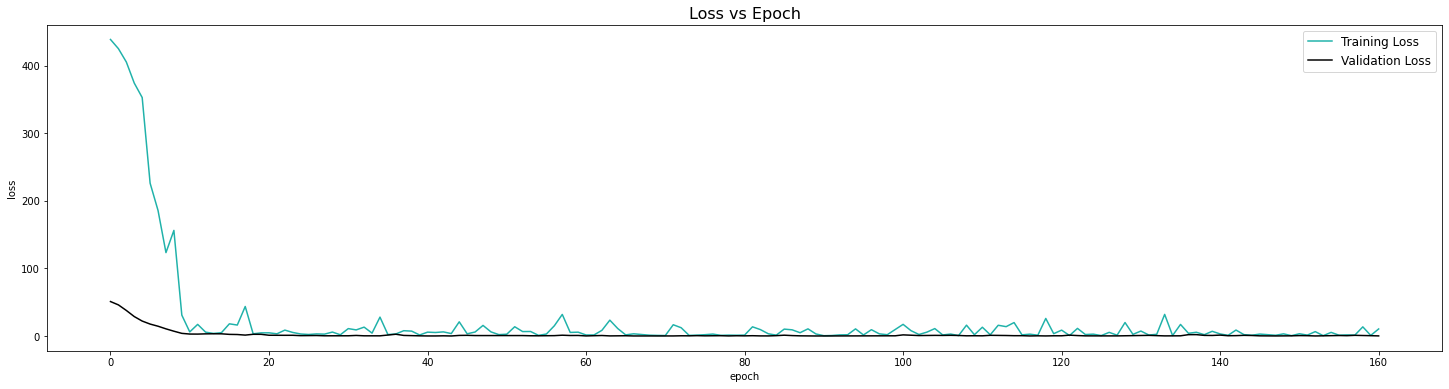

In [24]:
plt.rcParams["figure.figsize"] = [25, 6]

plt.plot(cnn_lstm_history.history['loss'], color = 'lightseagreen')
plt.plot(cnn_lstm_history.history['val_loss'], color = 'black')
plt.title('Loss vs Epoch', fontsize = 16)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='best', fontsize = 'large')
plt.show()

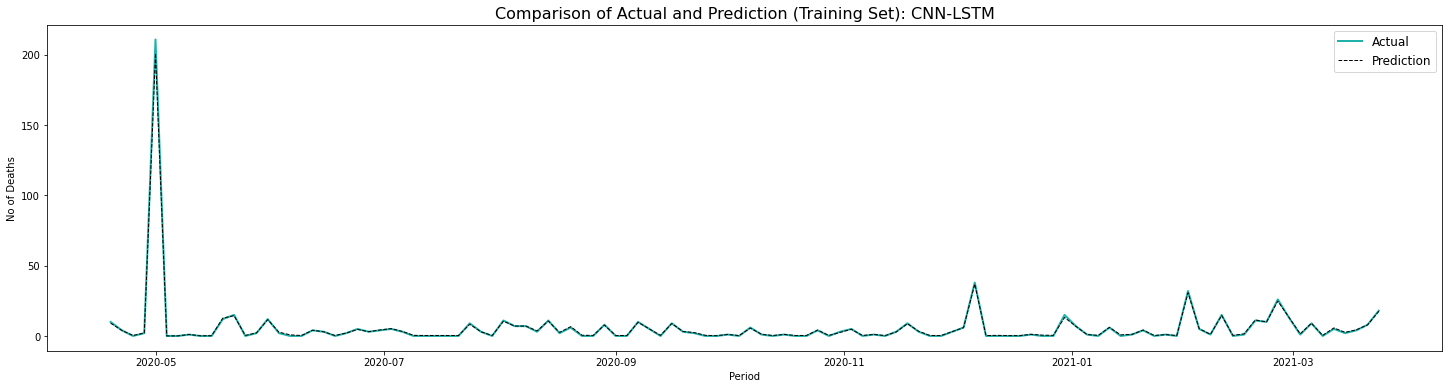

In [25]:
plt.rcParams["figure.figsize"] = [25, 6]

comparison_train.Deaths.plot(linewidth = 2, label = 'Actual', color = 'lightseagreen')
comparison_train.Prediction.plot(linewidth = 1, label = 'Prediction', color = 'black', linestyle = '--')
plt.legend(fontsize = 'large')
plt.ylabel('No of Deaths')
plt.title('Comparison of Actual and Prediction (Training Set): CNN-LSTM', fontsize = 16)
plt.show()

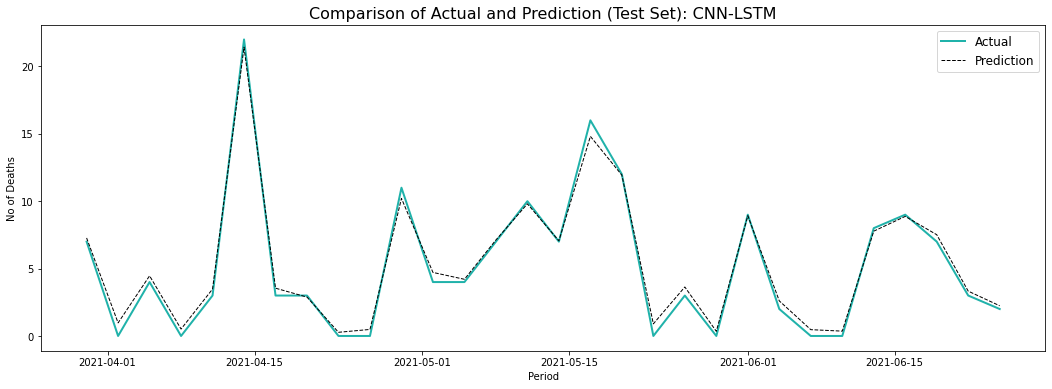

In [26]:
plt.rcParams["figure.figsize"] = [18, 6]

comparison.Deaths.plot(linewidth = 2, label = 'Actual', color = 'lightseagreen')
comparison.Prediction.plot(linewidth = 1, label = 'Prediction', color = 'black', linestyle = '--')
plt.legend(fontsize = 'large')
plt.ylabel('No of Deaths')
plt.title('Comparison of Actual and Prediction (Test Set): CNN-LSTM', fontsize = 16)
plt.show()

### Evaluation Metrics: Training Set

In [27]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison_train['Deaths'] - comparison_train['Prediction']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison_train['Deaths']).mean() * 100
r2 = r2_score(comparison_train['Deaths'], comparison_train['Prediction'])

In [28]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 0.4221
Mean Squared Error: 1.0525
Root Mean Square Error: 1.0259
Mean Absolute Percentage Error: inf
R2 Score: 0.9974


### Evaluation Metrics: Validation Set

In [29]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison['Deaths'] - comparison['Prediction']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison['Deaths']).mean() * 100
r2 = r2_score(comparison['Deaths'], comparison['Prediction'])

In [30]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 0.4284
Mean Squared Error: 0.2625
Root Mean Square Error: 0.5123
Mean Absolute Percentage Error: inf
R2 Score: 0.9904


### References

* https://colab.research.google.com/github/phylypo/TimeSeriesPrediction/blob/main/Time_Series_DL_LSTM_CNN.ipynb#scrollTo=LXuSM4llqGag